In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/content/train.csv",encoding = 'utf-8-sig',engine = "python")

In [3]:
df = df.sample(30000,random_state=2)

In [4]:
df.shape

(30000, 6)

In [5]:
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


In [6]:
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate
248328,248328,361730,361731,Does money exist?,Why does money exist?,0
282470,282470,127844,1213,What are some recommended movies a person shou...,What movies would you recommend everyone to wa...,1
40335,40335,72991,72992,How can you check your Capital One credit card...,How often does Capital One up my credit line w...,0
328463,328463,455004,455005,How can I add Dublin Core to a website?,How do you add Dublin Core to website?,1
364337,364337,494407,494408,Do we develop a tolerance to endorphin rushes?,How much can I raise my 3.77 weighted GPA as a...,0
234711,234711,345282,345283,"Having worked in Banking, what do you do now i...","Having worked in Banking, what do you do now i...",1
165513,165513,40833,121010,How do people still think the Earth is flat ev...,I know some people that STILL believe the eart...,1
399295,399295,72725,532546,How do you fall asleep fast when you are not t...,How can you avoid falling asleep easily?,0
90127,90127,151295,151296,What is Polavaram project issue and how the co...,How do peacocks build their nests?,0
58188,58188,102129,102130,Which is the best route to travel throughout I...,Which are the best ways to strengthen one's pr...,0


In [7]:
# missing values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [8]:
df["is_duplicate"].value_counts()

0    19013
1    10987
Name: is_duplicate, dtype: int64

In [9]:
(df["is_duplicate"].value_counts()/len(df))*100

0    63.376667
1    36.623333
Name: is_duplicate, dtype: float64

In [10]:
df['qid1']

398782    496695
115086    187729
327711    454161
367788    498109
151235    237843
           ...  
243932     26193
91980     154063
266955    133017
71112     122427
312470    436915
Name: qid1, Length: 30000, dtype: int64

In [11]:
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

In [12]:
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 55299
Number of questions getting repeated 3480


In [13]:
qid.value_counts()

2374      8
4044      8
11264     8
1063      7
2439      7
         ..
151429    1
243997    1
106522    1
110122    1
436916    1
Length: 55299, dtype: int64

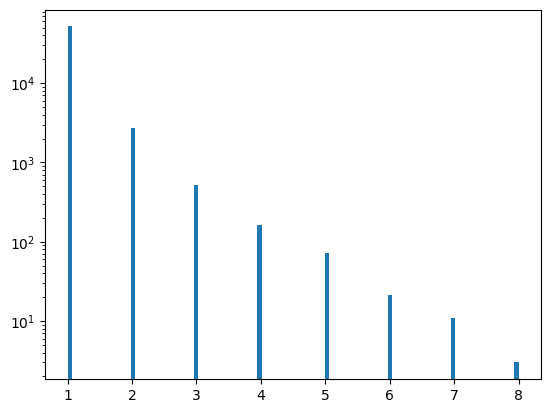

In [14]:
plt.hist(qid.value_counts().values, bins =100)
plt.yscale('log')
plt.show()

In [15]:
def preprocess(q):

    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()


    return q


In [16]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [17]:
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0


In [18]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

In [19]:
df["q1_no_of_words"] = df["question1"].apply(lambda row: len(row.split(" ")))
df["q2_no_of_words"] = df["question2"].apply(lambda row: len(row.split(" ")))


In [20]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_no_of_words,q2_no_of_words
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9


In [21]:
def common_words(row):
  wa = set(map(lambda word: word.lower().strip(), row["question1"].split(" ")))
  wb = set(map(lambda word: word.lower().strip(),row["question2"].split(" ")))
  return len(wa & wb)


In [22]:
df["common_words"] = df.apply(common_words,axis =1)

In [23]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_no_of_words,q2_no_of_words,common_words
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3


In [24]:
def total_words(row):
  wa = set(map(lambda word: word.lower().strip(), row["question1"].split(" ")))
  wb = set(map(lambda word: word.lower().strip(),row["question2"].split(" ")))
  return (len(wa) + len(wb))

In [25]:
df["total_words"] = df.apply(total_words,axis =1)

In [26]:
df["%similar words"] = np.round((df["common_words"]/df["total_words"])*100,2)

In [27]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_no_of_words,q2_no_of_words,common_words,total_words,%similar words
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26,46.15
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24,33.33
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38,10.53
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34,2.94
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13,23.08


In [28]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
from nltk.corpus import stopwords

In [30]:
def token_features(row):
  q1 = row["question1"]
  q2 = row["question2"]

  #Convert rows into tokens
  q1_tokens = q1.split()
  q2_tokens = q2.split()

  token_features = [0.0]*8

  if len(q1_tokens)==0 or len(q2_tokens)==0:
    return token_features

  # Select the stopwords
  stop_words = stopwords.words("english")

  # Get the non-stop words in questions:

  q1_words = set([word for word in q1_tokens if word not in stop_words])
  q2_words = set([word for word in q2_tokens if word not in stop_words])

  # Get the Stop words

  q1_stopwords = set([word for word in q1_tokens if word in stop_words])
  q2_stopwords = set([word for word in q2_tokens if word in stop_words])


  # Common non stop words
  common_word_count = len(q1_words.intersection(q2_words))

  # Common stop words
  common_stop_count = len(q1_stopwords.intersection(q2_stopwords))

  # Common_tokens
  common_tokens = len(set(q1_tokens).intersection(set(q2_tokens)))

  SAFE_DIV = 0.0001

  token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
  token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
  token_features[2] = common_stop_count / (min(len(q1_stopwords), len(q2_stopwords)) + SAFE_DIV)
  token_features[3] = common_stop_count / (max(len(q1_stopwords), len(q2_stopwords)) + SAFE_DIV)
  token_features[4] = common_tokens/ (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
  token_features[5] = common_tokens/ (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

  # Last words are same or not
  token_features[6] = int(q1_tokens[-1]==q2_tokens[-1])

  # First words are same or not
  token_features[7] = int(q1_tokens[0]==q2_tokens[0])

  return token_features


In [31]:
token_features = df.apply(token_features, axis=1)

In [32]:
token_features

398782    [0.874989062636717, 0.874989062636717, 0.99998...
115086    [0.6666444451851604, 0.49998750031249223, 0.71...
327711    [0.0, 0.0, 0.4285653062099113, 0.2727247934109...
367788                 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0]
151235    [0.7499812504687383, 0.5999880002399952, 0.0, ...
                                ...                        
243932    [0.7499812504687383, 0.7499812504687383, 0.999...
91980     [0.5999880002399952, 0.4285653062099113, 0.199...
266955    [0.499993750078124, 0.499993750078124, 0.33332...
71112     [0.49998750031249223, 0.3999920001599968, 0.59...
312470    [0.5999940000599994, 0.49999583336805525, 0.19...
Length: 30000, dtype: object

In [33]:
df["cwc_min"] = list(map(lambda x: x[0], token_features))
df["cwc max"] = list(map(lambda x: x[1], token_features))
df["csc_min"] = list(map(lambda x: x[2], token_features))
df["csc_max"] = list(map(lambda x: x[3], token_features))
df["ctc_min"] = list(map(lambda x: x[4], token_features))
df["ctc_max"] = list(map(lambda x: x[5], token_features))
df["last_word_eq"] = list(map(lambda x: x[6], token_features))
df["first_word_eq"]= list(map(lambda x: x[7], token_features))

In [34]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
!pip install distance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import distance

def fetch_length_features(row):

    q1 = row['question1']
    q2 = row['question2']

    length_features = [0.0]*3

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    #strs = list(distance.lcsubstrings(q1, q2))
    #length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)

    return length_features

In [37]:
df.shape

(30000, 21)

In [38]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
#df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))


In [39]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_no_of_words,q2_no_of_words,...,cwc_min,cwc max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,0.874989,0.874989,0.999980,0.999980,0.923070,0.923070,1.0,1.0,0.0,13.0
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,0.666644,0.499988,0.714276,0.624992,0.583328,0.466664,1.0,1.0,3.0,13.5


In [40]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [41]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [42]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_no_of_words', 'q2_no_of_words', 'common_words',
       'total_words', '%similar words', 'cwc_min', 'cwc max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'fuzz_ratio', 'fuzz_partial_ratio',
       'token_sort_ratio', 'token_set_ratio'],
      dtype='object')

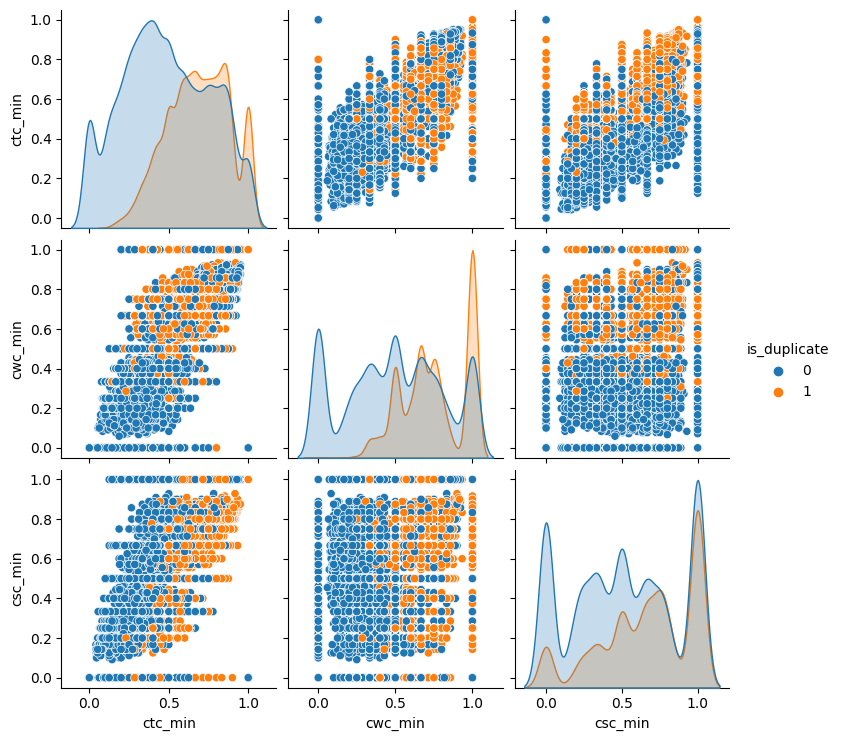

In [43]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

In [44]:
#sns.pairplot(df[['ctc_max', 'cwc max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

In [45]:
#sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [46]:

from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(df[['cwc_min', 'cwc max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' ]])
y = df['is_duplicate'].values


In [47]:
# from sklearn.manifold import TSNE

# tsne2d = TSNE(
#     n_components=2,
#     init='random', # pca
#     random_state=101,
#     method='barnes_hut',
#     n_iter=1000,
#     verbose=2,
#     angle=0.5
# ).fit_transform(X)

In [48]:
# tsne3d = TSNE(
#     n_components=3,
#     init='random', # pca
#     random_state=101,
#     method='barnes_hut',
#     n_iter=1000,
#     verbose=2,
#     angle=0.5
# ).fit_transform(X)

In [49]:
# tsne3d = TSNE(
#     n_components=3,
#     init='random', # pca
#     random_state=101,
#     method='barnes_hut',
#     n_iter=1000,
#     verbose=2,
#     angle=0.5
# ).fit_transform(X)

In [50]:
# import plotly.graph_objs as go
# import plotly.tools as tls
# import plotly.offline as py
# py.init_notebook_mode(connected=True)

# trace1 = go.Scatter3d(
#     x=tsne3d[:,0],
#     y=tsne3d[:,1],
#     z=tsne3d[:,2],
#     mode='markers',
#     marker=dict(
#         sizemode='diameter',
#         color = y,
#         colorscale = 'Portland',
#         colorbar = dict(title = 'duplicate'),
#         line=dict(color='rgb(255, 255, 255)'),
#         opacity=0.75
#     )
# )

# data=[trace1]
# layout=dict(height=800, width=800, title='3d embedding with engineered features')
# fig=dict(data=data, layout=layout)
# py.iplot(fig, filename='3DBubble')

In [51]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
398782,what is the best marketing automation tool for...,what is the best marketing automation tool for...
115086,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...
327711,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...
367788,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...
151235,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy


In [52]:
final_df = df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(30000, 22)


,is_duplicate,q1_len,q2_len,q1_no_of_words,q2_no_of_words,common_words,total_words,%similar words,cwc_min,cwc max,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,1,75,76,13,13,12,26,46.15,0.874989,0.874989,...,0.923070,0.923070,1.0,1.0,0.0,13.0,99,99,99,99
115086,0,48,56,13,16,8,24,33.33,0.666644,0.499988,...,0.583328,0.466664,1.0,1.0,3.0,13.5,69,67,65,74
327711,0,104,119,28,21,4,38,10.53,0.000000,0.000000,...,0.149999,0.115384,0.0,0.0,6.0,23.0,26,29,34,43
367788,0,58,145,14,32,1,34,2.94,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,17.0,21.5,29,41,23,30
151235,0,34,49,5,9,3,13,23.08,0.749981,0.599988,...,0.599988,0.333330,1.0,0.0,4.0,7.0,55,70,48,69


In [53]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [54]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [55]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(30000, 6022)


,is_duplicate,q1_len,q2_len,q1_no_of_words,q2_no_of_words,common_words,total_words,%similar words,cwc_min,cwc max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
398782,1,75,76,13,13,12,26,46.15,0.874989,0.874989,...,0,0,0,0,0,0,0,0,0,0
115086,0,48,56,13,16,8,24,33.33,0.666644,0.499988,...,0,0,0,0,0,0,0,0,0,0
327711,0,104,119,28,21,4,38,10.53,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
367788,0,58,145,14,32,1,34,2.94,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0
151235,0,34,49,5,9,3,13,23.08,0.749981,0.599988,...,0,0,0,0,0,0,0,0,0,0


In [87]:
final_df.columns[:23]

Index([      'is_duplicate',             'q1_len',             'q2_len',
           'q1_no_of_words',     'q2_no_of_words',       'common_words',
              'total_words',     '%similar words',            'cwc_min',
                  'cwc max',            'csc_min',            'csc_max',
                  'ctc_min',            'ctc_max',       'last_word_eq',
            'first_word_eq',       'abs_len_diff',           'mean_len',
               'fuzz_ratio', 'fuzz_partial_ratio',   'token_sort_ratio',
          'token_set_ratio',                    0],
      dtype='object')

In [56]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

AttributeError: ignored

In [63]:
from sklearn.metrics import confusion_matrix

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7861666666666667

In [65]:
# for random forest model
confusion_matrix(y_test,y_pred)

array([[3284,  528],
       [ 755, 1433]])

In [58]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.7933333333333333

In [ ]:
# XGB
confusion_matrix(y_test,y_pred)

In [74]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))
    return len(w1 & w2)

In [75]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))
    return (len(w1) + len(w2))

In [76]:
def test_fetch_token_features(q1,q2):

    SAFE_DIV = 0.0001

    STOP_WORDS = stopwords.words("english")

    token_features = [0.0]*8

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))


    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features

In [98]:
def test_fetch_length_features(q1,q2):

    length_features = [0.0]*3

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    #Average Token Length of both Questions
    #length_features[1] = (len(q1_tokens) + len(q2_tokens))/2


    return length_features

In [91]:
def test_fetch_fuzzy_features(q1,q2):

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [101]:
def query_point_creator(q1, q2):

    input_query = []

    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)

    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))

    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))

    input_query.append(test_common_words(q1, q2))
    input_query.append(test_total_words(q1, q2))
    input_query.append(round(test_common_words(q1, q2) / test_total_words(q1, q2), 2))

    # fetch token features
    token_features = test_fetch_token_features(q1, q2)
    input_query.extend(token_features[:-1])  # Remove the last element

    # fetch length based features
    length_features = test_fetch_length_features(q1, q2)
    input_query.extend(length_features)

    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1, q2)
    input_query.extend(fuzzy_features)

    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()

    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()

    return np.hstack((np.array(input_query).reshape(1, 21), q1_bow, q2_bow))

In [104]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the core capital of India?'


In [105]:
rf.predict(query_point_creator(q1,q4))

array([1])

In [107]:
cv

CountVectorizer(max_features=3000)

In [108]:
import pickle

pickle.dump(rf,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))